In [1]:
import os
import torch
import torchvision

import torchvision.transforms as transforms
import numpy as np
import matplotlib.pylab as plt

from utils import FullyConnectedNN, compute_confusion_matrix

# Define hyperparameters etc.

In [2]:
datadir = '../datasets'
batch_size = 32
learning_rate = 0.001
num_epochs = 2
indim = 784
outdim = 10
hdim = 100
num_hidden = 2
print_every = 100

# Fully-connected neural network

In [3]:
fcnet = FullyConnectedNN(indim, outdim, hdim, num_hidden)

In [4]:
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnet.parameters(), lr=learning_rate)

In [5]:
# define transform to map data from a PIL.Image data type
# to a Tensor which is what pytorch uses
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

# (down)load training and testing datasets
emnist_traindata = torchvision.datasets.EMNIST(datadir, split='mnist', download=True, transform=transform)
emnist_testdata = torchvision.datasets.EMNIST(datadir, split='mnist', train=False, download=True, transform=transform)

train_num_examples, height, width = emnist_traindata.data.shape
test_num_examples, _, _ = emnist_testdata.data.shape

print('Training dataset has {train_num_examples}, test dataset has {test_num_examples}'.format(train_num_examples=train_num_examples, test_num_examples=test_num_examples))

Training dataset has 60000, test dataset has 10000


In [6]:
# create dataloader
trainloader = torch.utils.data.DataLoader(emnist_traindata, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(emnist_testdata, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# make weights trainable
fcnet.train()

# create training loop
training_loss = []
for epoch in range(num_epochs):
    for iteration, sample in enumerate(trainloader):
        data, labels = sample
        num_examples = data.shape[0]
        
        # pass sample through fully-connected net
        output = fcnet(data.reshape(-1, height*width))
        
        # compute loss
        loss = loss_fcn(output, labels)
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute accuracy
        _, prediction = torch.max(output.data, 1)
        batch_accuracy = (prediction == labels).sum().item() / num_examples
        
        batch_loss = loss.item()
        
        if iteration % print_every == 0:
            print('Epoch: {epoch}, Iteration: {iteration}, Loss: {loss:.2f}, Acc: {acc:.2f}'.format(epoch=epoch, iteration=iteration, loss=batch_loss, acc=batch_accuracy))
            
        training_loss.append(batch_loss)

Epoch: 0, Iteration: 0, Loss: 2.31, Acc: 0.16
Epoch: 0, Iteration: 100, Loss: 0.40, Acc: 0.84
Epoch: 0, Iteration: 200, Loss: 0.33, Acc: 0.84
Epoch: 0, Iteration: 300, Loss: 0.20, Acc: 0.94
Epoch: 0, Iteration: 400, Loss: 0.19, Acc: 0.91
Epoch: 0, Iteration: 500, Loss: 0.22, Acc: 0.91
Epoch: 0, Iteration: 600, Loss: 0.10, Acc: 0.94
Epoch: 0, Iteration: 700, Loss: 0.31, Acc: 0.91
Epoch: 0, Iteration: 800, Loss: 0.19, Acc: 0.97
Epoch: 0, Iteration: 900, Loss: 0.12, Acc: 0.97
Epoch: 0, Iteration: 1000, Loss: 0.04, Acc: 1.00
Epoch: 0, Iteration: 1100, Loss: 0.35, Acc: 0.88
Epoch: 0, Iteration: 1200, Loss: 0.18, Acc: 0.97
Epoch: 0, Iteration: 1300, Loss: 0.03, Acc: 1.00
Epoch: 0, Iteration: 1400, Loss: 0.02, Acc: 1.00
Epoch: 0, Iteration: 1500, Loss: 0.23, Acc: 0.91
Epoch: 0, Iteration: 1600, Loss: 0.10, Acc: 0.97
Epoch: 0, Iteration: 1700, Loss: 0.04, Acc: 1.00
Epoch: 0, Iteration: 1800, Loss: 0.17, Acc: 0.91
Epoch: 1, Iteration: 0, Loss: 0.04, Acc: 1.00
Epoch: 1, Iteration: 100, Loss: 0.0

Text(0, 0.5, 'Cross Entropy Loss')

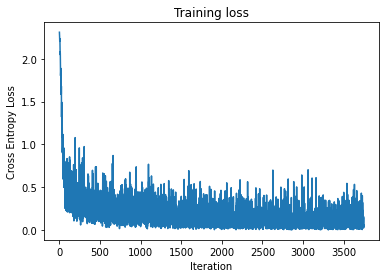

In [8]:
# plot training loss
plt.plot(training_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')

In [9]:
# make weights not trainable
fcnet.eval()

# compute average test loss and accuracy
prediction_label_data = []
total_loss = 0
total_correct = 0
total_examples = 0
for iteration, sample in enumerate(testloader):
    data, labels = sample
    num_examples = data.shape[0]

    # pass sample through fully-connected net
    output = fcnet(data.reshape(-1, height*width))

    # compute loss
    loss = loss_fcn(output, labels)
        
    # compute accuracy
    _, batch_prediction = torch.max(output.data, 1)
    batch_correct = (batch_prediction == labels).sum().item()
    batch_accuracy = batch_correct / num_examples

    batch_loss = loss.item()

    total_loss += batch_loss
    total_correct += batch_correct
    total_examples += num_examples
    
    np_batch_prediction = batch_prediction.data.numpy()
    np_batch_labels = labels.data.numpy()
    np_data = data.data.numpy()
    prediction_label_data.extend(list(zip(np_batch_prediction, np_batch_labels, np_data)))
    

average_accuracy = total_correct / total_examples
average_loss = total_loss / iteration
    
print('Avg Loss: {loss:.2f}, Avg Acc: {acc:.2f}'.format(loss=average_loss, acc=average_accuracy))

Avg Loss: 0.10, Avg Acc: 0.97


Text(0.5, 1.0, 'Label: 0, Prediction 8')

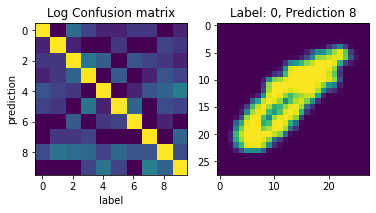

In [15]:
confusion_matrix, mistakes = compute_confusion_matrix(prediction_label_data)
# get image with wrong prediction
mistake_idx = np.random.randint(len(mistakes))
mistake_pred, mistake_label, mistake_data = mistakes[mistake_idx]
mistake_img = mistake_data.squeeze().T

plt.subplot(121)
plt.imshow(np.log(confusion_matrix))
plt.title('Log Confusion matrix')
plt.xlabel('label')
plt.ylabel('prediction')

plt.subplot(122)
plt.imshow(mistake_img)
plt.title('Label: {label}, Prediction {pred}'.format(label=mistake_label, pred=mistake_pred))

# Convolutional neural network

In [ ]:
class ConvolutionalNN(torch.nn.Module):
    '''
    
    https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
    '''
    def __init__(self, indim, outdim, hdim, num_hidden):
        '''
        '''
        super(FullyConnectedNN, self).__init__()
        
        self.indim = indim
        self.outdim = outdim
        self.hdim = hdim
        self.num_hidden = num_hidden
        
        # define layers
        # if there were two hidden layers processing would look like:
        # indim --> hdim --> nonlinearity --> hdim --> nonlinearity --> outdim
        # which would require the following mappings:
        # (indim --> hdim), (nonlinearity), (hdim --> hdim), (nonlinearity), (hdim --> outdim)
        in2hidden = torch.nn.Linear(indim, hdim)
        nonlinearity = torch.nn.ReLU()
        
        layers = [in2hidden, nonlinearity]
        for i in range(num_hidden - 1):
            hidden2hidden = torch.nn.Linear(hdim, hdim)
            nonlinearity = torch.nn.ReLU()
            layers.extend([hidden2hidden, nonlinearity])
            
        hidden2out = torch.nn.Linear(hdim, outdim)
        layers.append(hidden2out)
        
        self.model = torch.nn.Sequential(*layers)
        # print(self.model)
    
    def forward(self, data):
        return self.model.forward(data)